# Install library

In [1]:
import os
import random

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

#### Limit three class preprocessing

In [204]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_num = np.where(cifar10_labels=='bird')
deer_num = np.where(cifar10_labels=='deer')
truck_num = np.where(cifar10_labels=='truck')

limit_num = 2500

# get limit label indexes
bird_indexes = [i for i, label in enumerate(y_train) if label == bird_num]
deer_indexes = [i for i, label in enumerate(y_train) if label == deer_num] 
truck_indexes = [i for i, label in enumerate(y_train) if label == truck_num] 
other_indexes = [i for i, label in enumerate(y_train) if label not in [bird_num, deer_num, truck_num]]

# limit
bird_indexes = bird_indexes[:limit_num]
deer_indexes = deer_indexes[:limit_num]
truck_indexes = truck_indexes[:limit_num]
print(f'Bird label num is {len(bird_indexes)}') # 2500
print(f'Deer label num is {len(deer_indexes)}') # 2500
print(f'Truck label num is {len(truck_indexes)}') # 2500
print(f'Other label num is {len(other_indexes)}') # 35000; 5000*7

# merge and sort
merge_indexes = np.concatenate([other_indexes, bird_indexes, deer_indexes, truck_indexes], 0)
merge_indexes.sort()
print(f'Train label num is {len(merge_indexes)}') # 42500

# create three labels removed train data
x_train_removed =  np.zeros((len(merge_indexes), 32, 32, 3))
y_train_removed =  np.zeros(len(merge_indexes))

for i, train_index in enumerate(merge_indexes):
    x_train_removed[i] = x_train[train_index]
    y_train_removed[i] = y_train[train_index]
    
print(x_train_removed.shape)
print(y_train_removed.shape)

Bird label num is 2500
Deer label num is 2500
Truck label num is 2500
Other label num is 35000
Train label num is 42500
(42500, 32, 32, 3)
(42500,)


#### Oversampling

In [15]:
# train test split
# stratify y label
x_train_, x_valid_, y_train_, y_valid_ = train_test_split(x_train, y_train, 
                                                                      test_size=0.3, random_state=42, stratify=y_train)


# No method on keras to get cifar10 category label name by categoly label
cifar10_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

# get target label num
# y_train_ = y_train_removed[train_index]
df_train = pd.DataFrame(y_train_, columns=['label'])
target_index = df_train[df_train['label'] == cifar10_labels.index('dog')].index # bird label
limit_num = len(target_index)

# concat nate for over sampling
train_index_oversampling = np.concatenate([
    # target label
    df_train[df_train['label'] == cifar10_labels.index('bird')].sample(limit_num, random_state=42).index.values, # bird
    df_train[df_train['label'] == cifar10_labels.index('deer')].sample(limit_num, random_state=42).index.values, # deer
    df_train[df_train['label'] == cifar10_labels.index('truck')].sample(limit_num, random_state=42).index.values, # truck
    # other label
    df_train[df_train['label'] == cifar10_labels.index('airplane')].index.values,
    df_train[df_train['label'] == cifar10_labels.index('automobile')].index.values,
    df_train[df_train['label'] == cifar10_labels.index('cat')].index.values,
    df_train[df_train['label'] == cifar10_labels.index('dog')].index.values,
    df_train[df_train['label'] == cifar10_labels.index('frog')].index.values,
    df_train[df_train['label'] == cifar10_labels.index('horse')].index.values,
    df_train[df_train['label'] == cifar10_labels.index('ship')].index.values
])

# get train data for over sampling
x_train_over = x_train_[train_index_oversampling]
y_train_over = y_train_[train_index_oversampling]

print(f'Over sampling num is {limit_num}, total train num is {len(train_index_oversampling)}')

Over sampling num is 3500, total train num is 35000


In [209]:
# merge and sort
target_indexes = np.concatenate([bird_indexes, deer_indexes, truck_indexes], 0)
target_indexes.sort()
print(f'Target label num is {len(target_indexes)}') # 7500
print(f'Other label num is {len(other_indexes)}') # 35000

# create three labels removed train data
x_train_target =  np.zeros((len(target_indexes), 32, 32, 3))
y_train_target =  np.zeros(len(target_indexes))

for i, train_index in enumerate(target_indexes):
    x_train_target[i] = x_train[train_index]
    y_train_target[i] = y_train[train_index]

x_train_other =  np.zeros((len(other_indexes), 32, 32, 3))
y_train_other =  np.zeros(len(other_indexes))

for i, train_index in enumerate(other_indexes):
    x_train_other[i] = x_train[train_index]
    y_train_other[i] = y_train[train_index]

Target label num is 7500
Other label num is 35000


In [18]:
# df = pd.DataFrame(y_train_removed.flatten())
df = pd.DataFrame(y_train_over.flatten())
print(df.value_counts())
del df

9    3500
8    3500
7    3500
6    3500
5    3500
4    3500
3    3500
2    3500
1    3500
0    3500
dtype: int64


(array([3500., 3500., 3500., 3500., 3500., 3500., 3500., 3500., 3500.,
        3500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

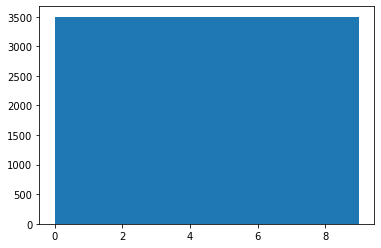

In [17]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_over.flatten())

## AutoEncoder

#### Load AE models weight

In [21]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path, encode_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        self.encoder.load_weights(encode_model_path)

In [22]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
stack01 = AE01(ae_ksize, ae_optimizer)
stack01.load_weights('../models/AE/AE01_AE_Best.hdf5', '../models/AE/AE01_Encoder_Best.hdf5')
stack01.encoder.trainable = False
stack01.encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


## Train

#### Create Model AE to CNN

In [23]:
def create_StackedAE01_CNN01_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 16,16,64
    
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) # 8,8,128
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x)

    return Model(input_img, y)

model01 = create_StackedAE01_CNN01_model(stack01.encoder)
model01.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)       

#### Under sampling without data augumentation

In [25]:
%%time

adam = Adam() # defalut
model01.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

# one hot encoding
nb_classes = 10
y_train_over_onehot = to_categorical(y_train_over, nb_classes)
y_valid_over_onehot = to_categorical(y_valid_, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

# train
saveDir = "../models/CNN/"

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_017_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

model01_history = model01.fit(x_train_over, y_train_over_onehot,
                      batch_size=32,
                      epochs=400,
                      verbose=1,
                      validation_data=(x_valid_, y_valid_over_onehot),
                      callbacks=[es_cb, cp_cb],
                      shuffle=True)

Epoch 1/400
1094/1094 [==============================] - ETA: 0s - loss: 1.3999 - accuracy: 0.4951
Epoch 00001: val_loss improved from inf to 1.31913, saving model to ../models/CNN\Model_017_Best.hdf5
1094/1094 [==============================] - 6s 6ms/step - loss: 1.3999 - accuracy: 0.4951 - val_loss: 1.3191 - val_accuracy: 0.5507
Epoch 2/400
1094/1094 [==============================] - ETA: 0s - loss: 0.9918 - accuracy: 0.6453
Epoch 00002: val_loss improved from 1.31913 to 1.03808, saving model to ../models/CNN\Model_017_Best.hdf5
1094/1094 [==============================] - 6s 5ms/step - loss: 0.9918 - accuracy: 0.6453 - val_loss: 1.0381 - val_accuracy: 0.6410
Epoch 3/400
1087/1094 [============================>.] - ETA: 0s - loss: 0.8195 - accuracy: 0.7100
Epoch 00003: val_loss did not improve from 1.03808
1094/1094 [==============================] - 6s 5ms/step - loss: 0.8187 - accuracy: 0.7103 - val_loss: 1.0830 - val_accuracy: 0.6355
Epoch 4/400
1083/1094 [======================

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

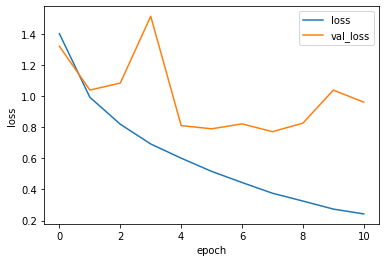

<Figure size 432x288 with 0 Axes>

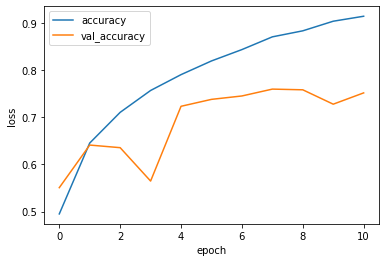

In [26]:
# plot training
mdoel01_hist_df = pd.DataFrame(model01_history.history)

plt.figure()
mdoel01_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
mdoel01_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [27]:
model01.load_weights('../models/CNN/Model_017_Best.hdf5')
model01.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 1s 2ms/step - loss: 0.7836 - accuracy: 0.7523


[0.7836481928825378, 0.7523000240325928]

In [28]:
y_pred = model01.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.87      0.78      1000
           1       0.83      0.92      0.87      1000
           2       0.60      0.68      0.64      1000
           3       0.68      0.47      0.55      1000
           4       0.77      0.65      0.71      1000
           5       0.61      0.78      0.69      1000
           6       0.82      0.77      0.79      1000
           7       0.78      0.86      0.82      1000
           8       0.92      0.78      0.84      1000
           9       0.91      0.76      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



#### Under sampling with data augumentation

In [29]:
%%time

model02 = create_StackedAE01_CNN01_model(stack01.encoder)
adam = Adam() # defalut
model02.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

# one hot encoding
nb_classes = 10
y_train_over_onehot = to_categorical(y_train_over, nb_classes)
y_valid_over_onehot = to_categorical(y_valid_, nb_classes)
y_test_onehot = to_categorical(y_test, nb_classes)

es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
chkpt = saveDir + 'Model_018_Best.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     shear_range=0.2,
    horizontal_flip=True,
#     vertical_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    zoom_range=0.1
#     channel_shift_range=0.2
    )

batch_size = 32
train_datagenerator = train_datagen.flow(x_train_over, y_train_over_onehot, batch_size)
valid_datagenerator = ImageDataGenerator().flow(x_valid_, y_valid_over_onehot, batch_size)

model02_history = model02.fit_generator(train_datagenerator,
                              steps_per_epoch=int(len(x_train_over)//batch_size),
                              epochs=400,
                              validation_data=valid_datagenerator,
                              validation_steps=int(len(x_valid_)//batch_size),
                              verbose=1,
                              shuffle=True,
                              callbacks=[es_cb, cp_cb])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/400
1091/1093 [============================>.] - ETA: 0s - loss: 1.4690 - accuracy: 0.4654
Epoch 00001: val_loss improved from inf to 1.57531, saving model to ../models/CNN\Model_018_Best.hdf5
1093/1093 [==============================] - 10s 9ms/step - loss: 1.4684 - accuracy: 0.4656 - val_loss: 1.5753 - val_accuracy: 0.4901
Epoch 2/400
1092/1093 [============================>.] - ETA: 0s - loss: 1.0924 - accuracy: 0.6127
Epoch 00002: val_loss improved from 1.57531 to 1.16236, saving model to ../models/CNN\Model_018_Best.hdf5
1093/1093 [==============================] - 10s 9ms/step - loss: 1.0924 - accuracy: 0.6128 - val_loss: 1.1624 - val_accuracy: 0.6074
Epoch 3/400
1093/1093 [==============================] - ETA: 0s - loss: 0.9211 - accuracy: 0.6760
Epoch 00003: val_loss did not improve from 1.16236
1093/1093 [==============================] - 10s 9ms/step - loss: 0.9211 - accuracy: 0.6760 - val_lo

Text(0.5, 0, 'epoch')

<Figure size 432x288 with 0 Axes>

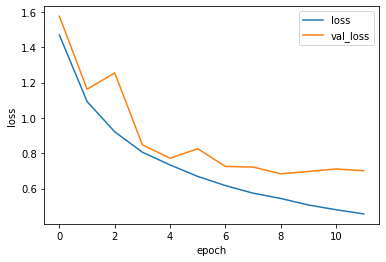

<Figure size 432x288 with 0 Axes>

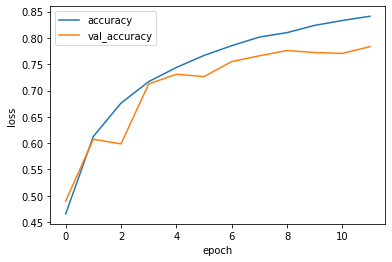

In [30]:
# plot training
model02_hist_df = pd.DataFrame(model02_history.history)

plt.figure()
model02_hist_df[['loss', 'val_loss']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.figure()
model02_hist_df[['accuracy', 'val_accuracy']].plot()
plt.ylabel('loss')
plt.xlabel('epoch')

In [31]:
model02.load_weights('../models/CNN/Model_018_Best.hdf5')
model02.evaluate(x_test, y_test_onehot)

313/313 [==============================] - 1s 3ms/step - loss: 0.6871 - accuracy: 0.7717


[0.687100887298584, 0.7717000246047974]

In [32]:
y_pred = model02.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.69      0.79      1000
           1       0.86      0.88      0.87      1000
           2       0.69      0.72      0.70      1000
           3       0.65      0.55      0.60      1000
           4       0.85      0.62      0.72      1000
           5       0.67      0.77      0.71      1000
           6       0.71      0.88      0.78      1000
           7       0.76      0.89      0.82      1000
           8       0.93      0.80      0.86      1000
           9       0.80      0.92      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

